## CS345 Fall 2023 Assignment 4


## Part 1:  Linear regression on medical insurance data

We will try to predict insurance charges based on a collection of features that include age, gender, body-mass-index (BMI), number of children, whether a person smokes, and the region in the US the live in.
Since the file contains string data in addition to numeric data let's first read the file using the Python `requests` module:

In [1]:
import requests
# if you don't have requests installed you can use urlopen which is part
# of the python standard library
# from urllib.request import urlopen
link = "https://github.com/asabenhur/CS345/raw/master/fall22/data/insurance.csv"
# retrieve the contents of the file
contents = requests.get(link)

Let's take a look at the first five rows of the data:

In [2]:
contents.text.split()[:5]

['age,sex,bmi,children,smoker,region,charges',
 '19,female,27.9,0,yes,southwest,16884.924',
 '18,male,33.77,1,no,southeast,1725.5523',
 '28,male,33,3,no,southeast,4449.462',
 '33,male,22.705,0,no,northwest,21984.47061']

As you can see the header specifies the names of the features:

```
age,sex,bmi,children,smoker,region,charges
```

The names are self explanatory.  We will use the last column as our label/target variable, and try to predict it from the other variables.

Since the data is a mix of numerical and categorical variables, we will need to do some work to create a feature matrix from this file.

This data has three types of features:

* Numerical data (the age, bmi, and children features)
* Categorical data that has one of two values (the sex and smoker features)
* Categorical data that has more than two possible values.  The "region" feature has the values "southwest", "southeast", "northwest", and "northeast".

Numerical data can be left as is (but may need to be standardized); binary categorical data can be converted to 0/1.  Categorical variables with more than two possible values require a different approach, which is called "one-hot-encoding", where each value receives its own feature, and the single categorical variable is replaced with a set of features.  The number of features equals the number of unique values that the categorical variable takes, and a categorical value is encoded as a vector of zeros, with a single value of one in the feature that corresponds to the given value.  Let us demonstrate this using the one-hot-encoder of scikit-learn on our "region" variable:

In [3]:
from sklearn.preprocessing import OneHotEncoder

# a mock dataset of regions:
X = [['southwest'], ['southeast'], ['northwest'], ['northeast']]
# create an instance of one hot encoder
encoder = OneHotEncoder()
# apply it to the data:
encoder.fit_transform(X).toarray()
# we have converted the output of fit_transform from a sparse array
# type to a regular NumPy array so we can easily see the values

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In your code you may not use the scikit-learn one-hot-encoder.

Now, you might ask why not simply encode these four values using the number 0-3.  The issue with doing that is that this representation imposes an order on the values, an order that does not necessarily reflect the interpretation of these features in the real world.

Your tasks are as follows:

* Create a feature matrix and labels vector from the given data as described above.
* Split the data into separate train and test sets with 30% of the data reserved for testing.
* Evaluate the error of linear regression on the train and test sets.  In doing so, first standardize the features.  Note that not all the features should be standardized - only the age and BMI features need that, because they are significantly larger than one.  You can use the scikit-learn implementations for linear regression, but note that its implementation for standardization does not provide the necessary flexibility to perform standardization on a selected set of features only.  Note that when standardizing, *only the features need to be standardized*.  The labels should remain unaltered.
* As discussed in class, the magnitude of the components of the weight vector provide an indication of the usefulness of a feature. Using the components of the weight vector, choose a subset of the features that are most useful for the regression task (use the absolute value of the weight, because large negative values also suggest usefulness).  Compare the error before and after removing the features with the lowest weight vector components.  Comment on your results.

For computing regression error use mean asbsolute error (MAE).

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

data = pd.read_csv(link)
X = data.drop(columns=['charges'])
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [42]:
scaler = StandardScaler()
scaler.fit(X_train[['age', 'bmi']])

X_train[['age', 'bmi']] = scaler.transform(X_train[['age', 'bmi']])
X_test[['age', 'bmi']] = scaler.transform(X_test[['age', 'bmi']])

categorical_features = ['sex', 'smoker', 'region']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

model = LinearRegression()
model.fit(X_train_encoded, y_train)

y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE on train set:", mae_train)
print("MAE on test set:", mae_test)

MAE on train set: 4251.2557986144875
MAE on test set: 4145.4505556276035


In [43]:
feature_weights = abs(model.coef_)

print("Feature Weights:")
for feature, weight in zip(X_train_encoded.columns, feature_weights):
    print(f"{feature}: {weight:.2f}")

top_n = min(3, len(feature_weights))

top_n_features_indices = feature_weights.argsort()[-top_n:][::-1]

top_n_features = X_train_encoded.columns[top_n_features_indices]

print("Top", top_n, "features:")
for feature in top_n_features:
    print(feature)

X_train_top = X_train_encoded[top_n_features]
X_test_top = X_test_encoded[top_n_features]

model.fit(X_train_top, y_train)

y_test_pred_top = model.predict(X_test_top)

mae_test_top = mean_absolute_error(y_test, y_test_pred_top)

print("MAE on test set with top features:", mae_test_top)


Feature Weights:
age: 3688.58
bmi: 2091.00
children: 424.12
sex_female: 52.41
sex_male: 52.41
smoker_no: 11814.18
smoker_yes: 11814.18
region_northeast: 596.06
region_northwest: 109.12
region_southeast: 374.91
region_southwest: 330.27
Top 3 features:
smoker_no
smoker_yes
age
MAE on test set with top features: 4001.9492803955222


I selected the top features based on the magnitude of the weight vector obtained from the Linear Regression model. The weight vector directly tells me the exact contribution for each feature to the prediction of insurance charges. Based on the weight vector for each feature I found that smoker status and age had the most contribution of each feature. Smoker status counts as two features because it was split into smoker_no and smoker_yes after one-hot encoding. 

## Part 2:  polynomial regression

In this part we will explore polynomial regression using the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), which is distributed with scikit-learn.

In [44]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data.data
y = data.target

A complete description of the dataset and its features is contained in the `DESCR` attribute of the dataset:

```python
print(data.DESCR)
```

Let's plot a histogram of the labels:

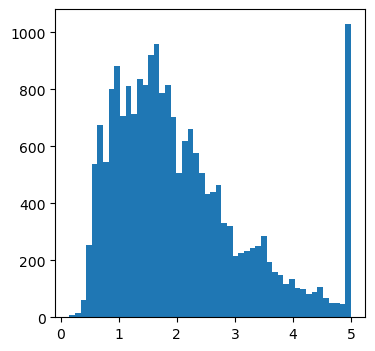

In [45]:
plt.figure(figsize=(4,4))
plt.hist(y, bins=50);

Here is your task:

* Compute the error of polynomial basis regression as a function of the degree of the polynomial for the Boston housing dataset.  Start with degree equal to 1, i.e. using the features as-is.  In each case compute accuracy for both the training set, and a separate test set.  Report the results as a nicely formatted table and comment on what you observe:  is there overfitting or underfitting?  You can use the scikit-learn [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) functionality in conjunction with the [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class as shown in class.  It is *highly recommended* to standardize the features for this task, and to include standardization as part of the pipeline.
* Choose a value of the degree for which polynomial basis regression yields overfitting.  We will use ridge regression to reduce the effect of overfitting.  Plot the accuracy of polynomial basis regression as a function of the regularization parameter $\alpha$ for both the training set and test set.  Is there a value of $\alpha$ for which you are able to obtain test set error that is similar or better than the error of linear regression?  Are you observing overfitting or underfitting in your plot?
* As a baseline, compute the error of a simple regression method that for a given regression problem always returns the median label value.  Compare this error with the error using linear regression and comment on the result.  Why is computing the error of this naive method a useful thing to do?

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Degree  MAE Train    MAE Test
0       1   0.528628    0.533200
1       2   0.460838    0.467001
2       3   0.416013    0.538679
3       4   0.373928    3.196681
4       5   0.335721  127.602343


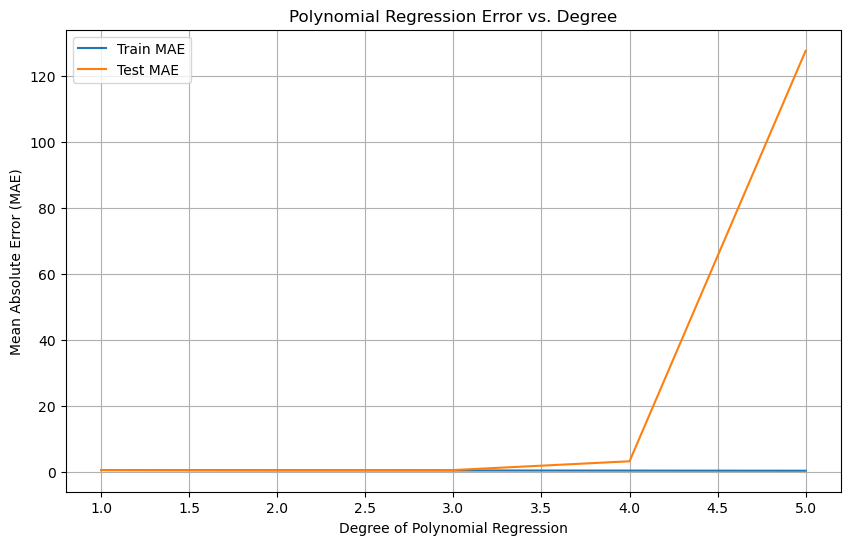

In [48]:
def polynomial_regression_error(X_train, y_train, X_test, y_test, degrees):
    results = []

    for degree in degrees:
        model = Pipeline([
            ('poly_features', PolynomialFeatures(degree=degree)),
            ('scaler', StandardScaler()),
            ('regression', LinearRegression())
        ])
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        
        results.append((degree, mae_train, mae_test))
    
    return results

degrees = [1, 2, 3, 4, 5]
results = polynomial_regression_error(X_train, y_train, X_test, y_test, degrees)

result_df = pd.DataFrame(results, columns=['Degree', 'MAE Train', 'MAE Test'])
print(result_df)

plt.figure(figsize=(10, 6))
plt.plot(result_df['Degree'], result_df['MAE Train'], label='Train MAE')
plt.plot(result_df['Degree'], result_df['MAE Test'], label='Test MAE')
plt.xlabel('Degree of Polynomial Regression')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Polynomial Regression Error vs. Degree')
plt.legend()
plt.grid()
plt.show()

     Alpha  MAE Train  MAE Test
0    0.001   0.422672  0.497003
1    0.010   0.429513  0.473921
2    0.100   0.437411  0.448195
3    1.000   0.447006  0.455739
4   10.000   0.460271  0.474271
5  100.000   0.477869  0.493307


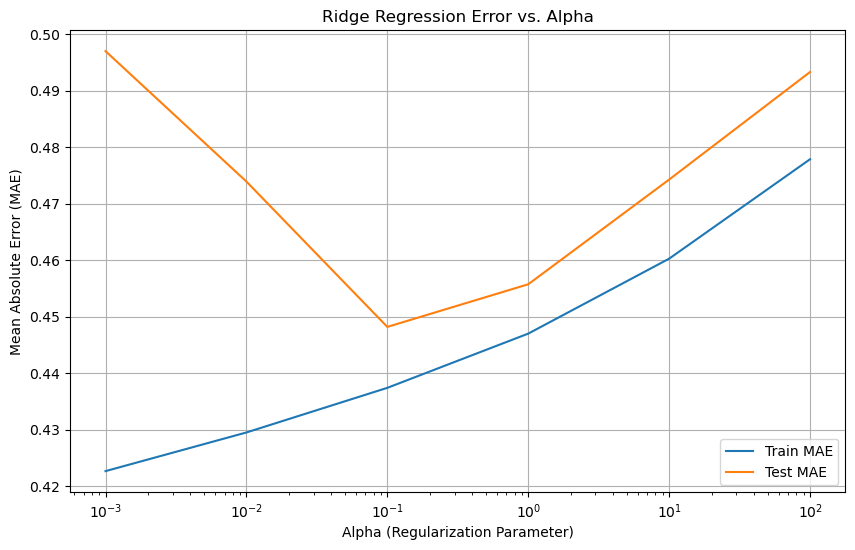

In [31]:
def ridge_regression_error(X_train, y_train, X_test, y_test, alpha_values):
    results = []

    for alpha in alpha_values:
        model = Pipeline([
            ('poly_features', PolynomialFeatures(degree=overfitting_degree)),
            ('scaler', StandardScaler()),
            ('regression', Ridge(alpha=alpha))
        ])
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        
        results.append((alpha, mae_train, mae_test))
    
    return results

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
overfitting_degree = 3

ridge_results = ridge_regression_error(X_train, y_train, X_test, y_test, alpha_values)
ridge_result_df = pd.DataFrame(ridge_results, columns=['Alpha', 'MAE Train', 'MAE Test'])
print(ridge_result_df)

plt.figure(figsize=(10, 6))
plt.semilogx(ridge_result_df['Alpha'], ridge_result_df['MAE Train'], label='Train MAE')
plt.semilogx(ridge_result_df['Alpha'], ridge_result_df['MAE Test'], label='Test MAE')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Ridge Regression Error vs. Alpha')
plt.legend()
plt.grid()
plt.show()

In [27]:
median_predictor_mae = mean_absolute_error(y_test, np.median(y_train) * np.ones_like(y_test))
print("MAE for Median Predictor:", median_predictor_mae)

linear_regression_mae = result_df[result_df['Degree'] == 1]['MAE Test'].values[0]
print("MAE for Linear Regression:", linear_regression_mae)

MAE for Median Predictor: 0.8740399224806202
MAE for Linear Regression (Degree 1): 0.5332001304956565


Based on my polynomial regression results, I found that as the degree increases, the more the model starts to overfit.

Based on the results I found from my ridge regression test, I can analyze whether it is better than the error of linear regression based on the value of alpha. I observed that for the lower alpha values, the test set error was similar to or better than the error of linear regression. As the alpha values get increasingly larger, the model starts to underfit, leading to higher test errors. As a result, the alpha value that I would choose would have to be either 0.001, 0.01, or 0.1.

My final test was to compare the error for the median predictor and compare that to the error for linear regression. Here are the results that I got from my test:

MAE for Median Predictor: 0.8740399224806202

MAE for Linear Regression (Degree 1): 0.5332001304956565

From my test, linear regression is better than the naive method based on the significantly different error values.

### Your Report

Answer the questions in the cells reserved for that purpose.

### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots in your notebook.

### Grading 

Although we will not grade on a 100 pt scale, the following is a grading sheet that will help you:


```
Grading sheet for assignment 4

Part 1:  5 points.
Dataset creation:  all the features were correctly converted to 
numerical values and the BMI and age values were standardized (1.5 pts)
Evaluation of linear regression (1.5 pts)
Feature selection based on weight vector magnitude, including discussion of the choice of features (2 pts)

Part 2:  5 points.
Train/test accuracy as a function of the degree of polynomial 
regression (1.5 pts)
Identification of model that exhibits overfitting (1 pt)
Successful application of ridge regression to prevent overfitting (2 pts)
Baseline comparison (0.5 pt)

```

Grading will be based on the following criteria:

  * Code correctness.
  * Code is well organized.
  * Plots and other results are well formatted and easy to understand.
  * Interesting and meaningful observations made where requested.